Я намерен представить это как простую в использовании, но тщательную исследовательскую задачу анализа данных с использованием 
О наборе данных
Этот набор данных содержит отзывы покупателей о том, подходит ли одежда по размеру, а также другую дополнительную информацию, такую как обзоры, рейтинги, категории товаров, размеры по каталогу, измерения клиентов (и т.д.).

In [3]:
import numpy as np  # линейная алгебра
import pandas as pd # обработка данных, ввод/вывод CSV-файла 
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Подавление всех предупреждений
import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rc('figure', figsize = (20, 8))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes.spines', top = False, right = False)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

<a id="2"></a>
# [Modcloth](http://modcloth.com) Набор данных
<a id="3"></a>
## Импорт данных с использованием Pandas
Взглянем на первые несколько строк json-файла modcloth data, используя встроенную команду OS bash-head.

Используя функцию pd.read_json(), файл json переносится во фрейм данных pandas с параметром *lines* как *True* - потому что каждый новый объект разделяется новой строкой.

In [5]:
mc_df = pd.read_json('modcloth_final_data.json', lines=True)
mc_df.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


<a id="4"></a>
# EDA - Исследовательский анализ данных

Здесь мы уже можем сделать несколько замечаний, взглянув на заголовок данных:
1. Во фрейме данных отсутствуют значения, которые необходимо обработать.
2. Размер чашки содержит несколько настроек, которые потребуется обработать, если мы хотим определить размеры чашки как тип данных "категория".
3. Столбец высоты необходимо проанализировать для извлечения высоты в числовом выражении, сейчас он выглядит как строка (объект).
4. Не так важно, но некоторые столбцы не помешало бы переименовать - для удаления пробелов.

Во-первых, мы обрабатываем именование столбцов для удобства доступа в pandas.

In [6]:
mc_df.columns

Index(['item_id', 'waist', 'size', 'quality', 'cup size', 'hips', 'bra size',
       'category', 'bust', 'height', 'user_name', 'length', 'fit', 'user_id',
       'shoe size', 'shoe width', 'review_summary', 'review_text'],
      dtype='object')

In [7]:
mc_df.columns = ['bra_size', 'bust', 'category', 'cup_size', 'fit', 'height', 'hips',
       'item_id', 'length', 'quality', 'review_summary', 'review_text',
       'shoe_size', 'shoe_width', 'size', 'user_id', 'user_name', 'waist']

In [8]:
mc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82790 entries, 0 to 82789
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bra_size        82790 non-null  int64  
 1   bust            2882 non-null   float64
 2   category        82790 non-null  int64  
 3   cup_size        82722 non-null  float64
 4   fit             76535 non-null  object 
 5   height          56064 non-null  float64
 6   hips            76772 non-null  float64
 7   item_id         82790 non-null  object 
 8   length          11854 non-null  object 
 9   quality         81683 non-null  object 
 10  review_summary  82790 non-null  object 
 11  review_text     82755 non-null  object 
 12  shoe_size       82790 non-null  object 
 13  shoe_width      82790 non-null  int64  
 14  size            27915 non-null  float64
 15  user_id         18607 non-null  object 
 16  user_name       76065 non-null  object 
 17  waist           76065 non-null 

Мы можем расширить наши наблюдения по отсутствующим данным и типам данных здесь:
* Из 18 столбцов только в 6 столбцах содержатся полные данные.
* Кажется, что отсутствует довольно много данных по бюсту, ширине обуви, размеру обуви и талии.
* Возможно, нам захочется обратить особое внимание на товары, которые ** имеют ** доступный размер обуви и ширину ботинка - возможно, это обувь!
* Многие столбцы содержат строки (тип данных объекта), которые необходимо преобразовать в тип данных категории (что также способствует эффективному потреблению памяти). 
 Столбец * *Талия* на удивление содержит много нулевых значений - учитывая, что большая часть данных из Modcloth поступает из 3 категорий "платья, топы и низ".

### Смотрим на процент пропущенных значений в столбце

In [9]:
missing_data = pd.DataFrame({'total_missing': mc_df.isnull().sum(), 'perc_missing': (mc_df.isnull().sum()/82790)*100})
missing_data

,total_missing,perc_missing
bra_size,0,0.000000
bust,79908,96.518903
category,0,0.000000
cup_size,68,0.082136
fit,6255,7.555260
height,26726,32.281677
hips,6018,7.268994
item_id,0,0.000000
length,70936,85.681846
quality,1107,1.337118


### Statistical description of numerical variables

In [10]:
mc_df.describe()

,bra_size,bust,category,cup_size,height,hips,shoe_width,size
count,82790.000000,2882.000000,82790.000000,82722.000000,56064.000000,76772.000000,82790.000000,27915.000000
mean,469325.229170,31.319223,12.661602,3.949058,40.358501,35.972125,498849.564718,8.145818
std,213999.803314,5.302849,8.271952,0.992783,5.827166,3.224907,286356.969459,1.336109
min,123373.000000,20.000000,0.000000,1.000000,30.000000,28.000000,6.000000,5.000000
25%,314980.000000,28.000000,8.000000,3.000000,36.000000,34.000000,252897.750000,7.000000
50%,454030.000000,30.000000,12.000000,4.000000,39.000000,36.000000,497913.500000,8.000000
75%,658440.000000,34.000000,15.000000,5.000000,43.000000,38.000000,744745.250000,9.000000
max,807722.000000,50.000000,38.000000,5.000000,60.000000,48.000000,999972.000000,38.000000


Еще несколько важных замечаний, прежде чем мы приступим к выполнению задач предварительной обработки наших данных:
* Размер бюстгальтера, бедра, возможно, не обязательно должны быть типом с плавающей категорией?
* Большинство размеров обуви составляют около 5-9, но максимальный размер обуви - 38! (Это удивительно, поскольку на веб-сайте используются размеры обуви в Великобритании.)
* Минимальный размер равен 0, а максимальный размер соответствует максимальному размеру обуви.

Давайте визуализируем числовые величины в нашем наборе данных в виде графиков, чтобы лучше понять отклонения.

<a id="5"></a>
## Блок-схема числовых переменных

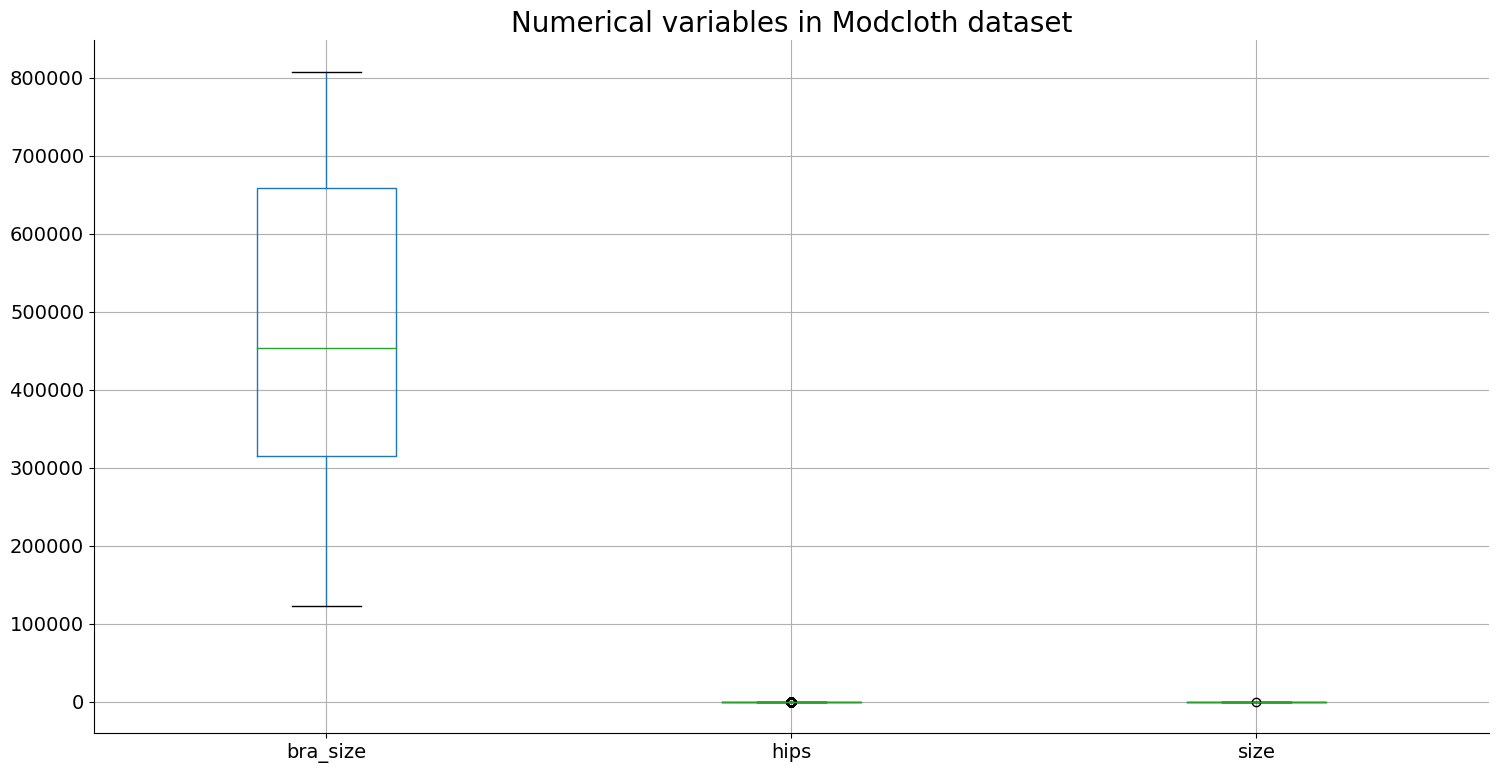

In [11]:
num_cols = ['bra_size','hips','quality','shoe_size','size','waist']
plt.figure(figsize=(18,9))
mc_df[num_cols].boxplot()
plt.title("Numerical variables in Modcloth dataset", fontsize=20)
plt.show()

<a id="6"></a>
## Обработка выбросов

* **shoe_size**:
Мы можем ясно видеть, что единственное максимальное значение размера обуви (38) является выбросом, и в идеале мы должны удалить эту строку или обработать это значение выброса. Давайте взглянем на эту запись в наших данных.

In [12]:
mc_df[mc_df.shoe_size == 38]

,bra_size,bust,category,cup_size,fit,height,hips,item_id,length,quality,review_summary,review_text,shoe_size,shoe_width,size,user_id,user_name,waist


>Мы видим, что ввод выглядит корректным, за исключением размера обуви - он мог быть неправильно введен клиентом или просто из-за шума. Пока мы введем это как нулевое значение.

In [13]:
mc_df.at[37313,'shoe_size'] = None

* **bra_size**:
Мы можем взглянуть на 10 лучших размеров бюстгальтеров (мы видим, что на графике показаны 2 значения в качестве выбросов, согласно IQR- межквартильному диапазону).

In [14]:
mc_df.sort_values(by=['bra_size'], ascending=False).head(10)

,bra_size,bust,category,cup_size,fit,height,hips,item_id,length,quality,review_summary,review_text,shoe_size,shoe_width,size,user_id,user_name,waist
82789,807722,NaN,4,4.0,d,39.0,32.0,outerwear,NaN,6ft,maireadsteadman,just right,fit,78305,NaN,NaN,I love this piece. I'm re,I love this piece. I'm really happy with it!
82766,807722,NaN,8,5.0,c,36.0,34.0,outerwear,NaN,5ft 7in,dana_johnson_1,just right,fit,33248,NaN,NaN,What a fabulous blazer!,What a fabulous blazer! It's made of a thicke...
82764,807722,NaN,4,5.0,NaN,NaN,NaN,outerwear,NaN,5ft 3in,Hufsa,just right,fit,475911,NaN,NaN,Perfect for work dresses.,Perfect for work dresses.
82763,807722,NaN,8,5.0,c,30.0,34.0,outerwear,NaN,5ft 1in,j.pastor19,just right,fit,747277,5.5,narrow,This jacket has shoulder,This jacket has shoulder pads in it going to ...
82762,807722,NaN,8,5.0,d,36.0,36.0,outerwear,NaN,5ft 4in,shara2179,just right,small,465791,NaN,NaN,"Was a bit hard to close,","Was a bit hard to close, but I was planning to..."
82760,807722,NaN,12,5.0,b,36.0,36.0,outerwear,NaN,5ft 10in,kochkrystal,just right,fit,392328,NaN,NaN,"Soft and stylish, I'm obs","Soft and stylish, I'm obsessed with this jacket!"
82759,807722,NaN,8,4.0,c,36.0,34.0,outerwear,NaN,5ft 6in,angelammcq,just right,fit,905432,NaN,NaN,Fits perfectly!,Fits perfectly!
82758,807722,NaN,4,5.0,c,35.0,32.0,outerwear,NaN,5ft 8in,nicholesullivan81,just right,fit,78267,NaN,NaN,This jacket is adorable!,This jacket is adorable! I purchased the white...
82757,807722,NaN,12,4.0,dd/e,35.0,36.0,outerwear,NaN,5ft 7in,Kavya,just right,fit,374234,NaN,NaN,I love how this works as,I love how this works as both a professional a...
82756,807722,NaN,12,4.0,c,38.0,34.0,outerwear,NaN,5ft 5in,Stacia,just right,fit,258653,NaN,NaN,I like how stretchy it is,I like how stretchy it is and the fit. I went ...


<a id="7"></a>
## Совместное распределение bra_size по размеру
Мы можем визуализировать распределение bra_size по размеру (двумерное), чтобы иметь представление о значениях.

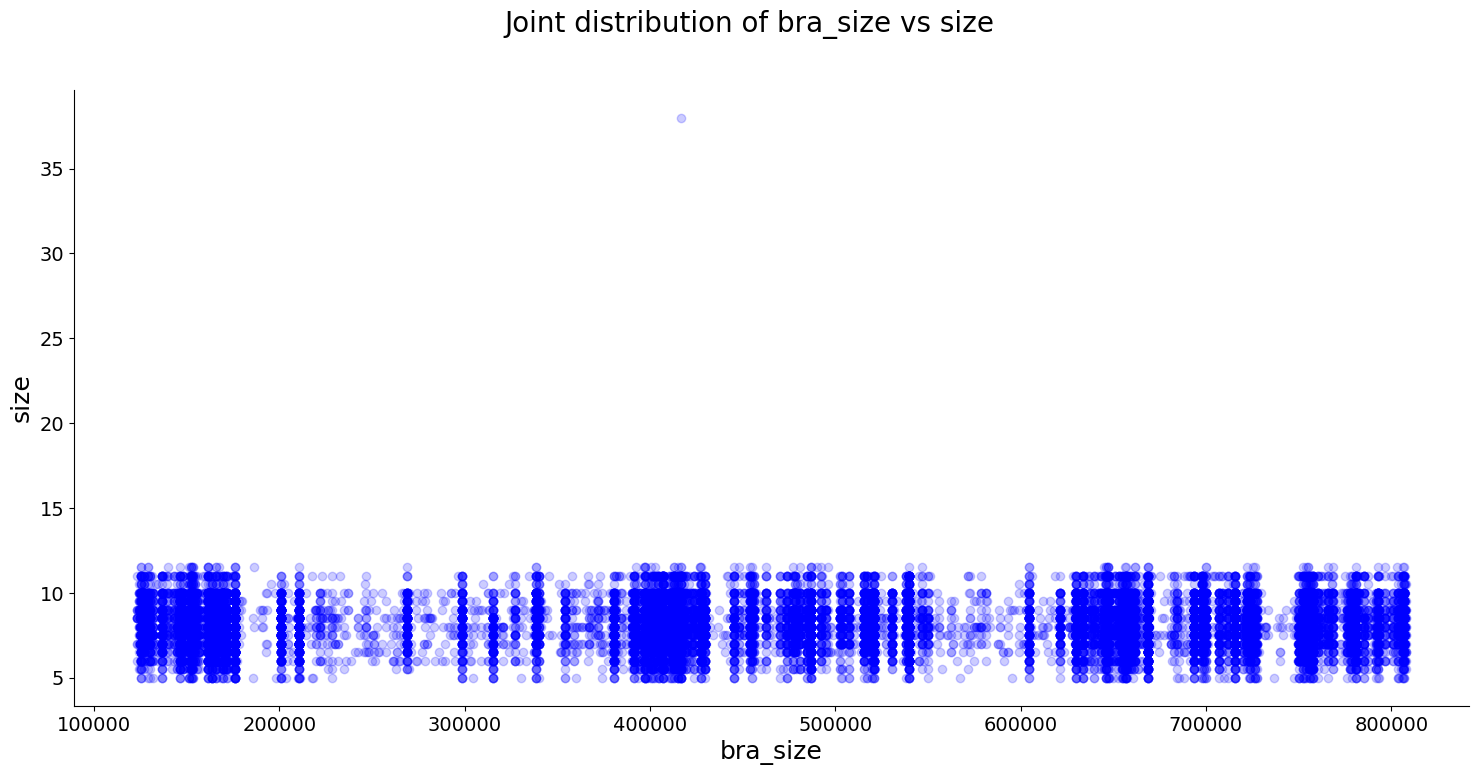

In [15]:
plt.figure(figsize=(18,8))
plt.xlabel("bra_size", fontsize=18)
plt.ylabel("size", fontsize=18)
plt.suptitle("Joint distribution of bra_size vs size", fontsize= 20)
plt.plot(mc_df.bra_size, mc_df['size'], 'bo', alpha=0.2)
plt.show()

>Мы не видим каких-либо существенных отклонений от обычного поведения для размера бюстгальтера, фактически и для всех других числовых переменных - мы можем ожидать, что "очевидные" выбросы, судя по графику, будут вести себя аналогично. Теперь мы перейдем к предварительной обработке набора данных для получения подходящих визуализаций.

<a id="8"></a>
# Очистка данных и предварительная обработка
Давайте обработаем переменные и изменим dtype на соответствующий тип для каждого столбца. Сначала мы определяем функцию для создания графика распределения различных переменных. Здесь представлено начальное распределение объектов.

**Примечание: Окончательные графики распределения приведены [ниже](#dist_plots).**

<a id="9"></a>
### Первоначальное распределение функций

TypeError: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.

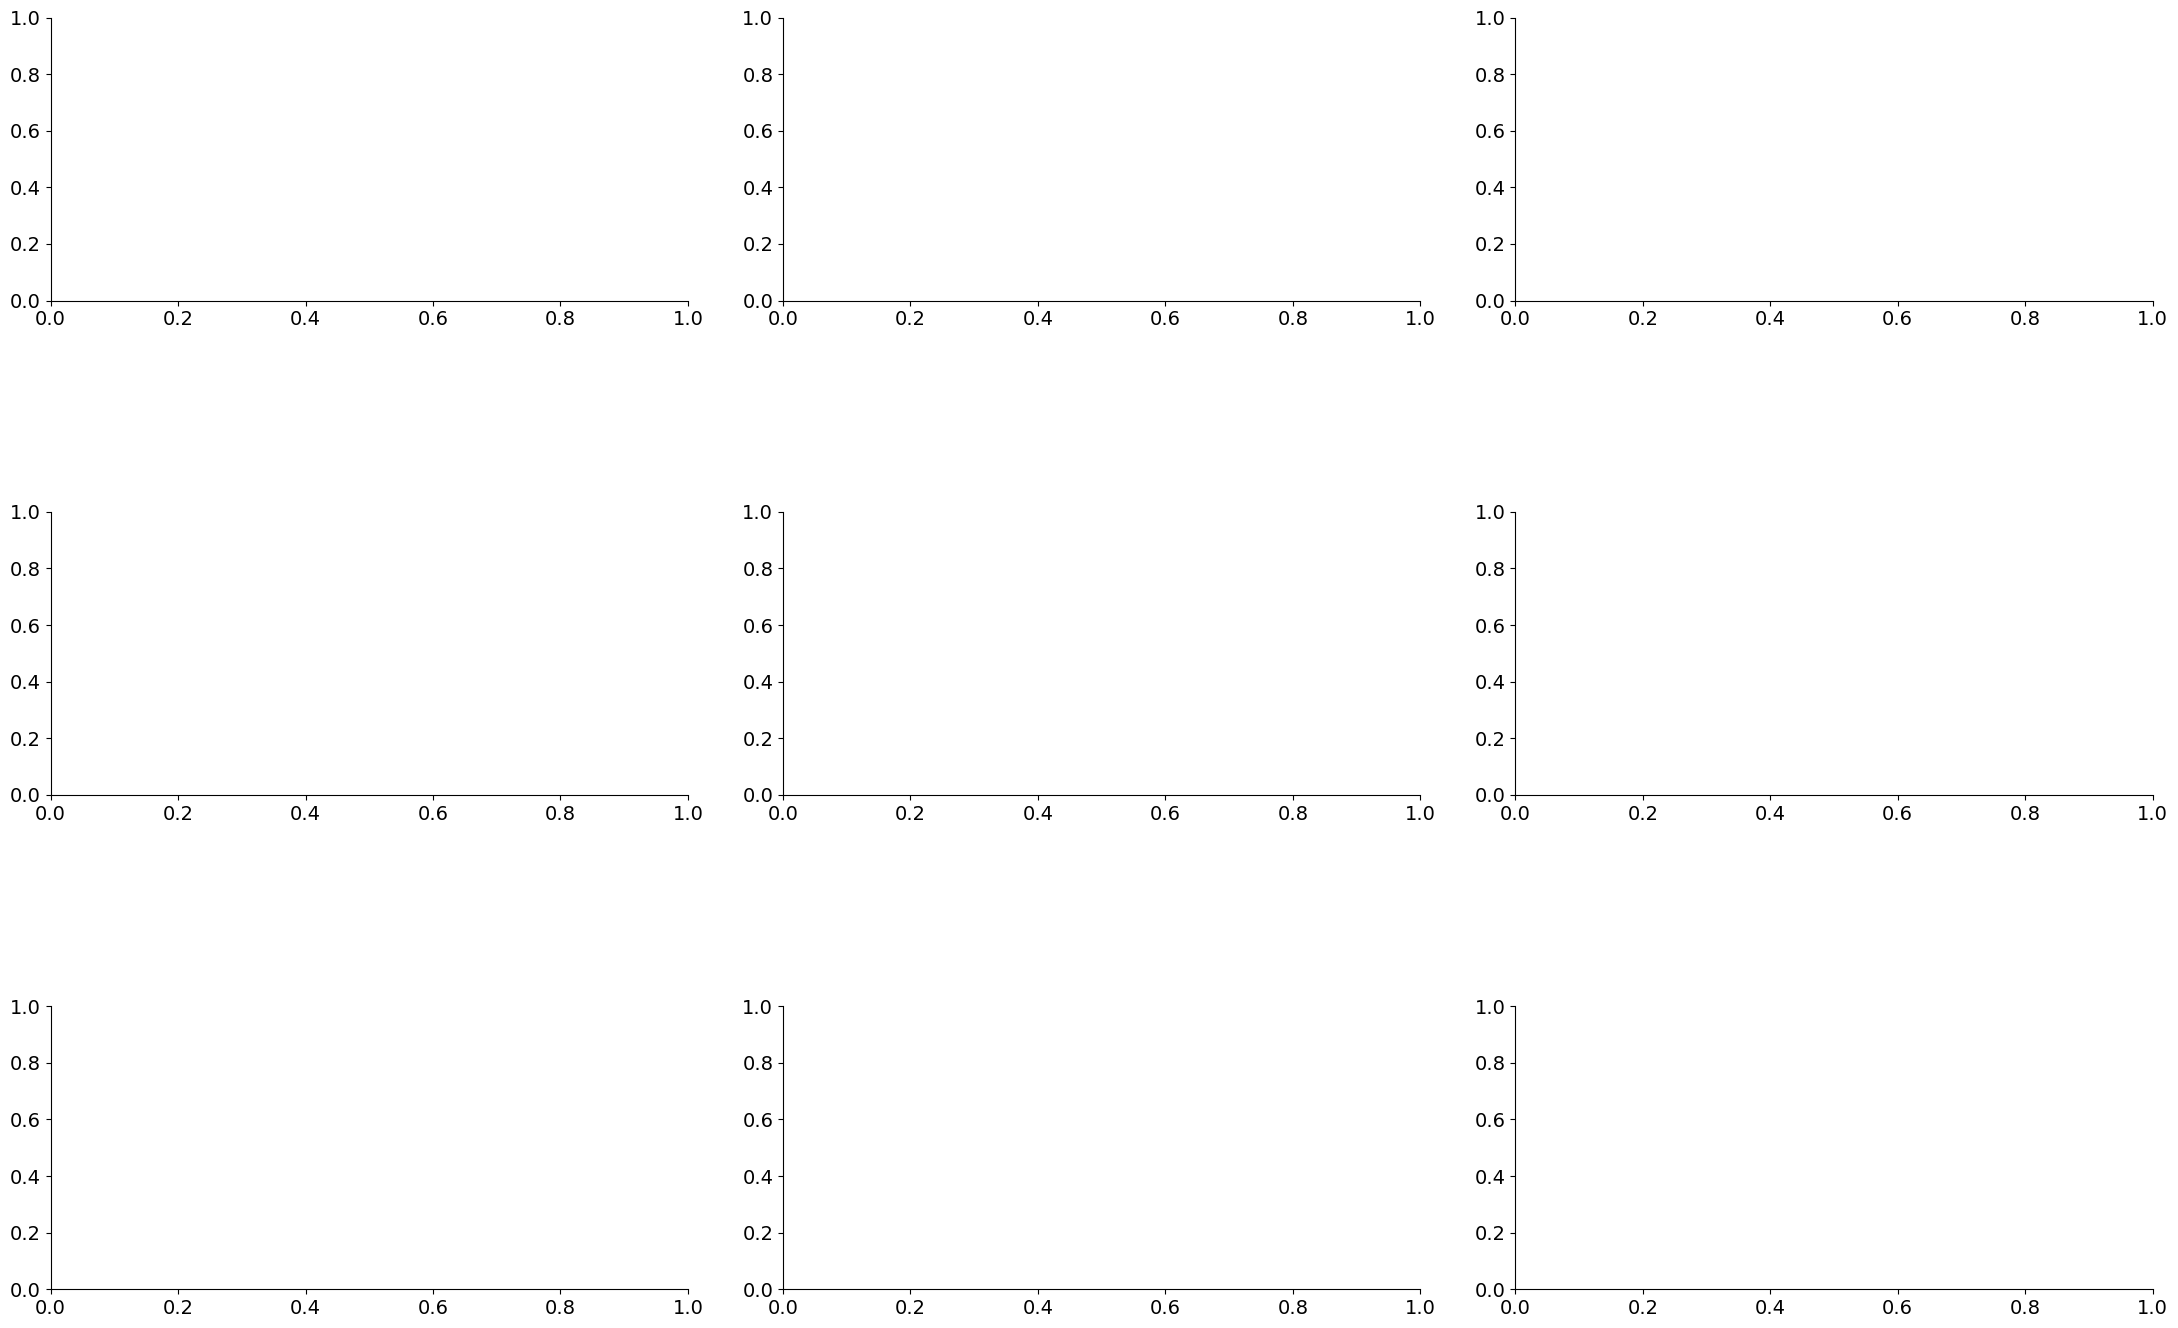

In [16]:
def plot_dist(col, ax):
    mc_df[col][mc_df[col].notnull()].value_counts().plot('bar', facecolor='y', ax=ax)
    ax.set_xlabel('{}'.format(col), fontsize=20)
    ax.set_title("{} on Modcloth".format(col), fontsize= 18)
    return ax

f, ax = plt.subplots(3,3, figsize = (22,15))
f.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])
cols = ['bra_size','bust', 'category', 'cup_size', 'fit', 'height', 'hips', 'length', 'quality']
k = 0
for i in range(3):
    for j in range(3):
        plot_dist(cols[k], ax[i][j])
        k += 1
__ = plt.suptitle("Initial Distributions of features", fontsize= 25)

<a id="10"></a>
### Пошаговая обработка функций:
* **размер бюстгальтера:** Хотя он выглядит числовым, он варьируется только от 28 до 48, при этом большинство размеров находятся в районе 34-38. Имеет смысл преобразовать это в *categorial* dtype. Мы добавим значения NA в категорию "Неизвестно". Выше мы видим, что у большинства покупателей размер бюстгальтера 34 или 36.
* **bust** - Посмотрев на значения, которые не являются null, мы можем увидеть, что bust должен быть целочисленным типом dtype. Нам также нужно обработать особый случай, когда bust задается как - '37-39'. Мы заменим запись '37-39' на среднее значение, т.е.- 38, для целей анализа. Теперь мы можем безопасно преобразовать dtype в int. Однако, учитывая, что **примерно 86% данных о переборе отсутствуют **, в конечном итоге было решено удалить эту функцию.
* **категория** - ничего не пропущено; измените на dtype *категория*.
* **размер чашки** - Измените dtype на *категория* для этого столбца. В этом столбце отсутствует около 7% значений. Просмотр строк, в которых отсутствует это значение, может

In [17]:
mc_df.bra_size = mc_df.bra_size.fillna('Unknown')
mc_df.bra_size = mc_df.bra_size.astype('category').cat.as_ordered()
mc_df.at[37313,'bust'] = '38'
mc_df.bust = mc_df.bust.fillna(0).astype(int)
mc_df.category = mc_df.category.astype('category')

In [18]:
mc_df[mc_df.cup_size.isnull()].sample(20)

,bra_size,bust,category,cup_size,fit,height,hips,item_id,length,quality,review_summary,review_text,shoe_size,shoe_width,size,user_id,user_name,waist
66397,696347,28,6,NaN,NaN,36.0,NaN,bottoms,NaN,5ft 6in,Nicolerenee13,just right,fit,349268,NaN,NaN,So soft!,I absolutely love the feeling of these legging...
63252,664417,35,15,NaN,b,41.0,38.0,new,39,5ft 6in,Annie,just right,fit,331559,8.5,average,"Very nice pants, good qua","Very nice pants, good quality fabric and great..."
22745,358694,0,4,NaN,NaN,NaN,NaN,sale,NaN,5ft 6in,Ulysses,slightly long,large,814416,NaN,NaN,"This dress is me personified: Dark green, has ...",I bought this for the opening of an entomology...
61115,657081,28,8,NaN,b,36.0,34.0,new,35,5ft 10in,meltycheese,just right,fit,258379,8.5,average,Average pencil skirt.,Seemed like an avereage pencil skirt. The wai...
3581,144486,0,20,NaN,ddd/f,NaN,40.0,new,NaN,5ft 1in,Lorraine,just right,large,60793,NaN,NaN,NaN,NaN
8537,160625,34,11,NaN,NaN,NaN,NaN,dresses,NaN,5ft 2in,Katie L,just right,large,792186,NaN,NaN,Perfect!,I bought this dress in a black friday sale for...
19832,289097,0,8,NaN,d,NaN,32.0,sale,NaN,5ft 6in,C4LL13,just right,fit,951751,7.0,NaN,Devastated the fit was terrible at the arms,This dress was soooo up my alley. Everything a...
63165,662713,29,8,NaN,b,39.0,36.0,sale,36,5ft 5in,instanthubbard,slightly long,fit,539488,8.0,average,Great jumpsuit,"I really like this jumpsuit, it's cute and the..."
16212,192939,0,12,NaN,c,NaN,38.0,dresses,NaN,5ft 7in,KateM89,just right,fit,661451,NaN,NaN,Absolutely beautiful!,I bought this dress to attend a lunchtime wedd...
73739,755526,27,4,NaN,b,39.0,34.0,bottoms,35,5ft 7in,AllieGato,just right,large,452287,8.5,NaN,"Cute skirt, but definitely size down",Just got this skirt for the second time. I fir...


>Однако мы не видим ничего бросающегося в глаза в строках, где отсутствуют эти данные, согласно куратору набора данных - "*** Обратите внимание, что эти наборы данных очень разрежены, и большинство продуктов и клиентов имеют только одну транзакцию. ***" Это указывает на то, что, возможно, эти клиенты еще не покупали нижнее белье у modcloth, поэтому у modcloth нет таких данных. Таким образом, имеет смысл заполнить эти нулевые значения как "Неизвестные". Исходя из распространенности таких значений, как dd/e, ddd/f и dddd/g, мы можем предположить, что это законные размеры чашек, что также подтверждается [**this**](https://www.herroom.com/full-figure-bra-cup-sizing,905,30.html ) статья, в которой некоторые бренды меняют размер чашки dd на e, ddd на f и т.д. Мы можем напрямую преобразовать это в *category* dtype.

* **подходит** - Измените dtype на *категория* для этого столбца. Мы видим, что подавляющее большинство покупателей дали хорошие отзывы о товарах на Modcloth!

In [19]:
mc_df.cup_size.fillna('Unknown', inplace=True)
mc_df.cup_size = mc_df.cup_size.astype('category').cat.as_ordered()

mc_df.fit = mc_df.fit.astype('category')

* **высота** - Нам нужно проанализировать столбец высоты, поскольку в настоящее время это строковый объект вида - Xft. Yin. Имеет смысл преобразовать высоту в cms. Мы также посмотрим на строки, в которых отсутствуют данные о высоте.

In [20]:
def get_cms(x):
    if type(x) == type(1.0):
        return
    #print(x)
    try: 
        return (int(x[0])*30.48) + (int(x[4:-2])*2.54)
    except:
        return (int(x[0])*30.48)
mc_df.height = mc_df.height.apply(get_cms)

In [21]:
mc_df[mc_df.height.isnull()].head(20)
# Посмотрите на выходные данные, чтобы лучше понять выводы!

,bra_size,bust,category,cup_size,fit,height,hips,item_id,length,quality,review_summary,review_text,shoe_size,shoe_width,size,user_id,user_name,waist
0,123373,29,7,5.0,d,None,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31,13,3.0,b,None,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30,7,2.0,b,None,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,0,21,5.0,dd/e,None,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,0,18,5.0,b,None,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN
5,123373,27,11,5.0,c,None,36.0,new,NaN,5ft 4in,Doreenajane,just right,small,162012,NaN,NaN,NaN,NaN
6,123373,26,5,1.0,b,None,32.0,new,NaN,5ft 3in,barbiejenks,just right,large,114843,NaN,NaN,NaN,NaN
7,123373,0,11,5.0,d,None,38.0,new,NaN,5ft 5in,brettloie,just right,small,58869,8.5,NaN,NaN,NaN
8,123373,0,30,4.0,d,None,42.0,new,NaN,5ft 10in,francescaviola,just right,small,279568,11.0,wide,NaN,NaN
9,123373,0,13,5.0,dd/e,None,36.0,new,39,5ft 6in,laurenpolzin,just right,fit,950172,9.0,NaN,NaN,NaN


> Эта фильтрация дает нам интересные наблюдения здесь:
> 1. Некоторые покупатели указали данные о размере бюстгальтера, чашки_размер, в то время как все остальные измерения пустые - возможна первая покупка нижнего белья в Modcloth!
> 2. Некоторые покупатели указали размер обуви, а все остальные размеры не указаны - возможна первая покупка обуви в Modcloth!
> 
> Это приводит нас к выводу, что в наборе данных есть несколько покупателей-новичков, о чем также говорили авторы данных в [1] - о разреженности данных из-за 1 транзакции! Кроме того, поскольку у нас нет данных о росте этих клиентов, имеет смысл оставить недостающие значения в столбце как есть и **, возможно, удалить эти строки для будущего статистического моделирования.** Мы удалили соответствующие строки.
>
>
><a id="11"></a>
> # Разработка функций 
> ## Создание новой функции first_time_user
> 
> Основываясь на наших наблюдениях выше, имеет смысл идентифицировать транзакции, которые принадлежат начинающим пользователям. Мы используем следующий

In [22]:
print(mc_df[((mc_df.bra_size != 'Unknown') | (mc_df.cup_size != 'Unknown')) & (mc_df.height.isnull()) & (mc_df.hips.isnull()) &
     (mc_df.shoe_size.isnull()) & (mc_df.shoe_width.isnull()) & (mc_df.waist.isnull())].head(3))
print(mc_df[(mc_df.bra_size == 'Unknown') & (mc_df.cup_size == 'Unknown') & (mc_df.height.isnull()) & (mc_df.hips.isnull()) &
     ((mc_df.shoe_size.notnull()) | (mc_df.shoe_width.notnull())) & (mc_df.waist.isnull())].head(3))
print(mc_df[(mc_df.bra_size == 'Unknown') & (mc_df.cup_size == 'Unknown') & (mc_df.height.isnull()) & ((mc_df.hips.notnull()) | (mc_df.waist.notnull())) &
     (mc_df.shoe_size.isnull()) & (mc_df.shoe_width.isnull())].head(3))

Empty DataFrame
Columns: [bra_size, bust, category, cup_size, fit, height, hips, item_id, length, quality, review_summary, review_text, shoe_size, shoe_width, size, user_id, user_name, waist]
Index: []
Empty DataFrame
Columns: [bra_size, bust, category, cup_size, fit, height, hips, item_id, length, quality, review_summary, review_text, shoe_size, shoe_width, size, user_id, user_name, waist]
Index: []
Empty DataFrame
Columns: [bra_size, bust, category, cup_size, fit, height, hips, item_id, length, quality, review_summary, review_text, shoe_size, shoe_width, size, user_id, user_name, waist]
Index: []


>Теперь мы добавляем новый столбец к исходным данным - *first_time_user*, который является функцией bool, которая указывает, является ли пользователь транзакции пользователем в первый раз или нет. Это основано на том основании, что у Modcloth нет предыдущей информации о человеке, фактически возможно, что новый пользователь совершил несколько транзакций в первый раз!

In [23]:
lingerie_cond = (((mc_df.bra_size != 'Unknown') | (mc_df.cup_size != 'Unknown')) & (mc_df.height.isnull()) & (mc_df.hips.isnull()) &
     (mc_df.shoe_size.isnull()) & (mc_df.shoe_width.isnull()) & (mc_df.waist.isnull()))
shoe_cond = ((mc_df.bra_size == 'Unknown') & (mc_df.cup_size == 'Unknown') & (mc_df.height.isnull()) & (mc_df.hips.isnull()) &
     ((mc_df.shoe_size.notnull()) | (mc_df.shoe_width.notnull())) & (mc_df.waist.isnull()))
dress_cond = ((mc_df.bra_size == 'Unknown') & (mc_df.cup_size == 'Unknown') & (mc_df.height.isnull()) & ((mc_df.hips.notnull()) | (mc_df.waist.notnull())) &
     (mc_df.shoe_size.isnull()) & (mc_df.shoe_width.isnull()))
#print(len(mc_df[lingerie_cond]))   # Чтобы проверить, совпадают ли эти элементы в последнем столбце, который мы добавляем.
#print(len(mc_df[shoe_cond]))
#print(len(mc_df[dress_cond]))
mc_df['first_time_user'] = (lingerie_cond | shoe_cond | dress_cond)
print("Column added!")
print("Total transactions by first time users who bought bra, shoes, or a dress: " + str(sum(mc_df.first_time_user)))
print("Total first time users: " + str(len(mc_df[(lingerie_cond | shoe_cond | dress_cond)].user_id.unique())))

Column added!
Total transactions by first time users who bought bra, shoes, or a dress: 0
Total first time users: 0


* **hips**-
В столбце Hips много пропущенных значений ~ 32,28%! Мы знаем, что эти данные, возможно, будут отсутствовать, потому что Modcloth, скорее всего, никогда не получал эти данные от пользователя. Мы не можем удалить такой значительный фрагмент данных, поэтому нам нужен другой способ обработки этой функции. Мы будем группировать данные - на основе квартилей.
* **длина** - В длину не хватает всего 35 строк, мы рассмотрим их. Мы увидели, что, скорее всего, клиенты не оставили отзывов или данные в этих строках были повреждены. Однако мы должны иметь возможность вычислять эти значения, используя поля, связанные с просмотром (если они заполнены!). Или мы также могли бы просто удалить эти строки. Для этого анализа мы удалим эти строки.
* **качество** - В качестве отсутствует всего 68 строк, мы рассмотрим их. Аналогично с длиной, клиенты не оставили отзывов или данные в этих строках были повреждены. Мы удалим эти строки и преобразуем dtype в порядковую переменную

In [24]:
# Handling hips column
mc_df.hips = mc_df.hips.fillna(-1.0)
bins = [-5,0,31,37,40,44,75]
labels = ['Unknown','XS','S','M', 'L','XL']
mc_df.hips = pd.cut(mc_df.hips, bins, labels=labels)

# Handling length column
missing_rows = mc_df[mc_df.length.isnull()].index
mc_df.drop(missing_rows, axis = 0, inplace=True)

# Handling quality
missing_rows = mc_df[mc_df.quality.isnull()].index
mc_df.drop(missing_rows, axis = 0, inplace=True)
mc_df.quality = mc_df.quality.astype('category').cat.as_ordered()

* **review_summary/ review_text** - Значения NA указаны потому, что эти отзывы просто не предоставлены клиентами. Давайте просто обозначим их как "Неизвестные".
* **shoe_size** - Примерно 66,3% данных shoe_size отсутствуют. Мы изменим shoe_size на *category* dtype и заполним значения NA как "Неизвестно".
* **ширина обуви** - Примерно 77,5% данных о ширине обуви отсутствуют. Мы заполним значения NA как "Неизвестные" 
* **талия** - В столбце талия наибольшее количество пропущенных значений - 96,5%! Мы удалим этот столбец.
* **бюст** - 85,6% пропущенных значений и сильно коррелирует с размером бюстгальтера. Удалять.
* **имя_пользователя** - само имя_пользователя не требуется при указанном user_id. Удалять.

Чтобы преобразовать shoe_width в упорядоченный тип категории, мы должны импортировать CategoricalDType и указать порядок категорий.

In [25]:
from pandas.api.types import CategoricalDtype
shoe_widths_type = CategoricalDtype(categories=['Unknown','narrow','average','wide'], ordered=True)

mc_df.review_summary = mc_df.review_summary.fillna('Unknown')
mc_df.review_text = mc_df.review_text.fillna('Unkown')
mc_df.shoe_size = mc_df.shoe_size.fillna('Unknown')
mc_df.shoe_size = mc_df.shoe_size.astype('category').cat.as_ordered()
mc_df.shoe_width = mc_df.shoe_width.fillna('Unknown')
mc_df.shoe_width = mc_df.shoe_width.astype(shoe_widths_type)
mc_df.drop(['waist', 'bust', 'user_name'], axis=1, inplace=True)
missing_rows = mc_df[mc_df.height.isnull()].index
mc_df.drop(missing_rows, axis = 0, inplace=True)

In [26]:
mc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   bra_size         0 non-null      category
 1   category         0 non-null      category
 2   cup_size         0 non-null      category
 3   fit              0 non-null      category
 4   height           0 non-null      object  
 5   hips             0 non-null      category
 6   item_id          0 non-null      object  
 7   length           0 non-null      object  
 8   quality          0 non-null      category
 9   review_summary   0 non-null      object  
 10  review_text      0 non-null      object  
 11  shoe_size        0 non-null      category
 12  shoe_width       0 non-null      category
 13  size             0 non-null      float64 
 14  user_id          0 non-null      object  
 15  first_time_user  0 non-null      bool    
dtypes: bool(1), category(8), float64(1), object(6)
memory usage: 

Мы видим, что теперь пропущенных значений больше нет! Мы можем перейти к визуализации и получению более глубокого представления о данных.

<a id="12"></a>
# EDA с помощью визуализаций

<a id="13"></a>
<a id='dist_plots'></a>
## 1. Распределение различных объектов по набору данных Modcloth

TypeError: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.

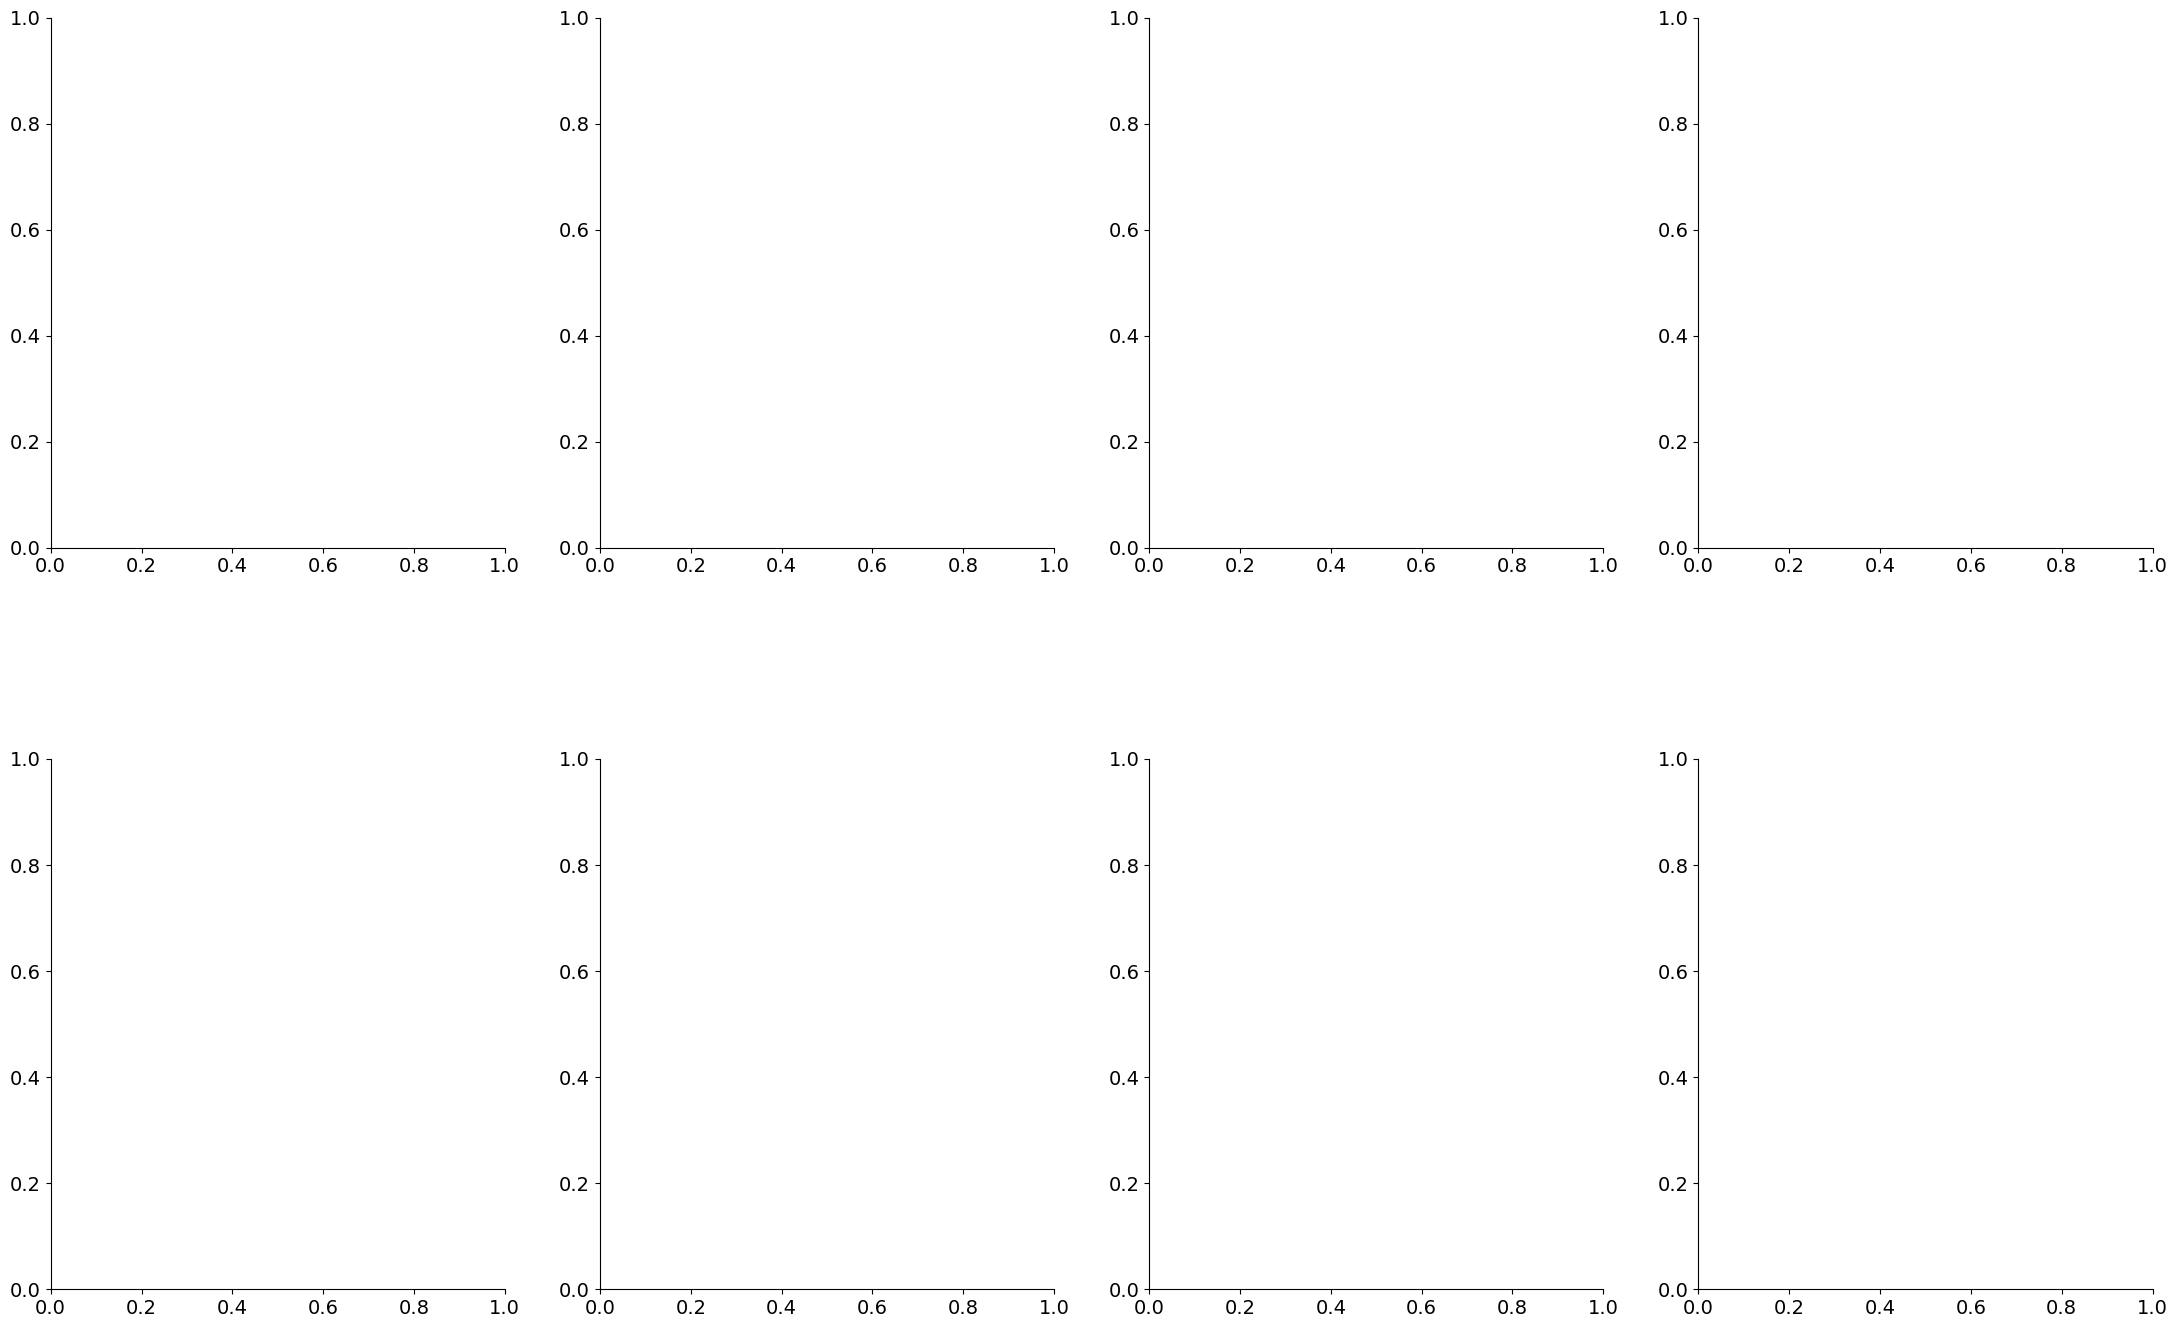

In [27]:
def plot_dist(col, ax):
    if col != 'height':
        mc_df[col].value_counts().plot('bar', facecolor='y', ax=ax)
    else:
        mc_df[col].plot('density', ax=ax, bw_method = 0.15, color='y')
        ax.set_xlim(130,200)
        ax.set_ylim(0, 0.07)
    ax.set_xlabel('{}'.format(col), fontsize=18)
    ax.set_title("{} on Modcloth".format(col), fontsize= 18)
    return ax

f, ax = plt.subplots(2,4, figsize = (22,15))
f.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])
cols = ['bra_size','category', 'cup_size', 'fit', 'height', 'hips', 'length', 'quality']
k = 0
for i in range(2):
    for j in range(4):
        plot_dist(cols[k], ax[i][j])
        k += 1
__ = plt.suptitle("Final Distributions of different features", fontsize= 23)

<a id="14"></a>
## 2. Категории в зависимости от подгонки/длины/качества
Здесь мы наглядно представим, как обстояли дела у товаров разных категорий с точки зрения подгонки, длины и качества. Это подскажет Modcloth, какие категории требуют большего внимания! 

Здесь я изобразил 2 распределения по категориям:

**1. Ненормализованное** - просмотр значений частоты напрямую - для сравнения по категориям. Мы также включаем в этот график показатель наилучшего соответствия, длины или качества.

**2. Нормализованный** - просмотр распределения для категории после нормализации количества в самой категории - это поможет нам сравнить, какие основные причины возврата в самой категории. Мы исключаем наилучшие показатели размера и качества, чтобы сосредоточиться на преобладающих причинах возврата в каждой категории (если таковые имеются).

In [28]:
def plot_barh(df,col, cmap = None, stacked=False, norm = None):
    df.plot(kind='barh', colormap=cmap, stacked=stacked)
    fig = plt.gcf()
    fig.set_size_inches(24,12)
    plt.title("Category vs {}-feedback -  Modcloth {}".format(col, '(Normalized)' if norm else ''), fontsize= 20)
    plt.ylabel('Category', fontsize = 18)
    plot = plt.xlabel('Frequency', fontsize=18)
    
def norm_counts(t):
    norms = np.linalg.norm(t.fillna(0), axis=1)
    t_norm = t[0:0]
    for row, euc in zip(t.iterrows(), norms):
        t_norm.loc[row[0]] = list(map(lambda x: x/euc, list(row[1])))
    return t_norm

In [29]:
mc_df.category.value_counts()

category
0     0
15    0
33    0
32    0
31    0
30    0
27    0
26    0
25    0
24    0
21    0
20    0
18    0
17    0
14    0
1     0
13    0
12    0
11    0
10    0
9     0
8     0
7     0
6     0
5     0
4     0
3     0
2     0
38    0
Name: count, dtype: int64

- **Категория в зависимости от соответствия**

In [31]:
g_by_category = mc_df.groupby('category')
cat_fit = g_by_category['fit'].value_counts()
cat_fit = cat_fit.unstack()
cat_fit_norm = norm_counts(cat_fit)
cat_fit_norm.drop(['fit'], axis=1, inplace=True)
plot_barh(cat_fit, 'fit')

KeyError: "['fit'] not found in axis"

Наблюдения:
* Наибольшее количество отзывов о наилучшей посадке (*fit*) было получено в категориях *новинка, платья и топы*. 
* В целом максимальное количество отзывов о плохой посадке относится в основном к 2 категориям- *новинка и топы*! Далее следуют категории *Платья и низ*. 
* *Свадьбы, верхняя одежда и распродажи* не выделяются в нашей визуализации - в основном из-за отсутствия сделок в этих категориях.

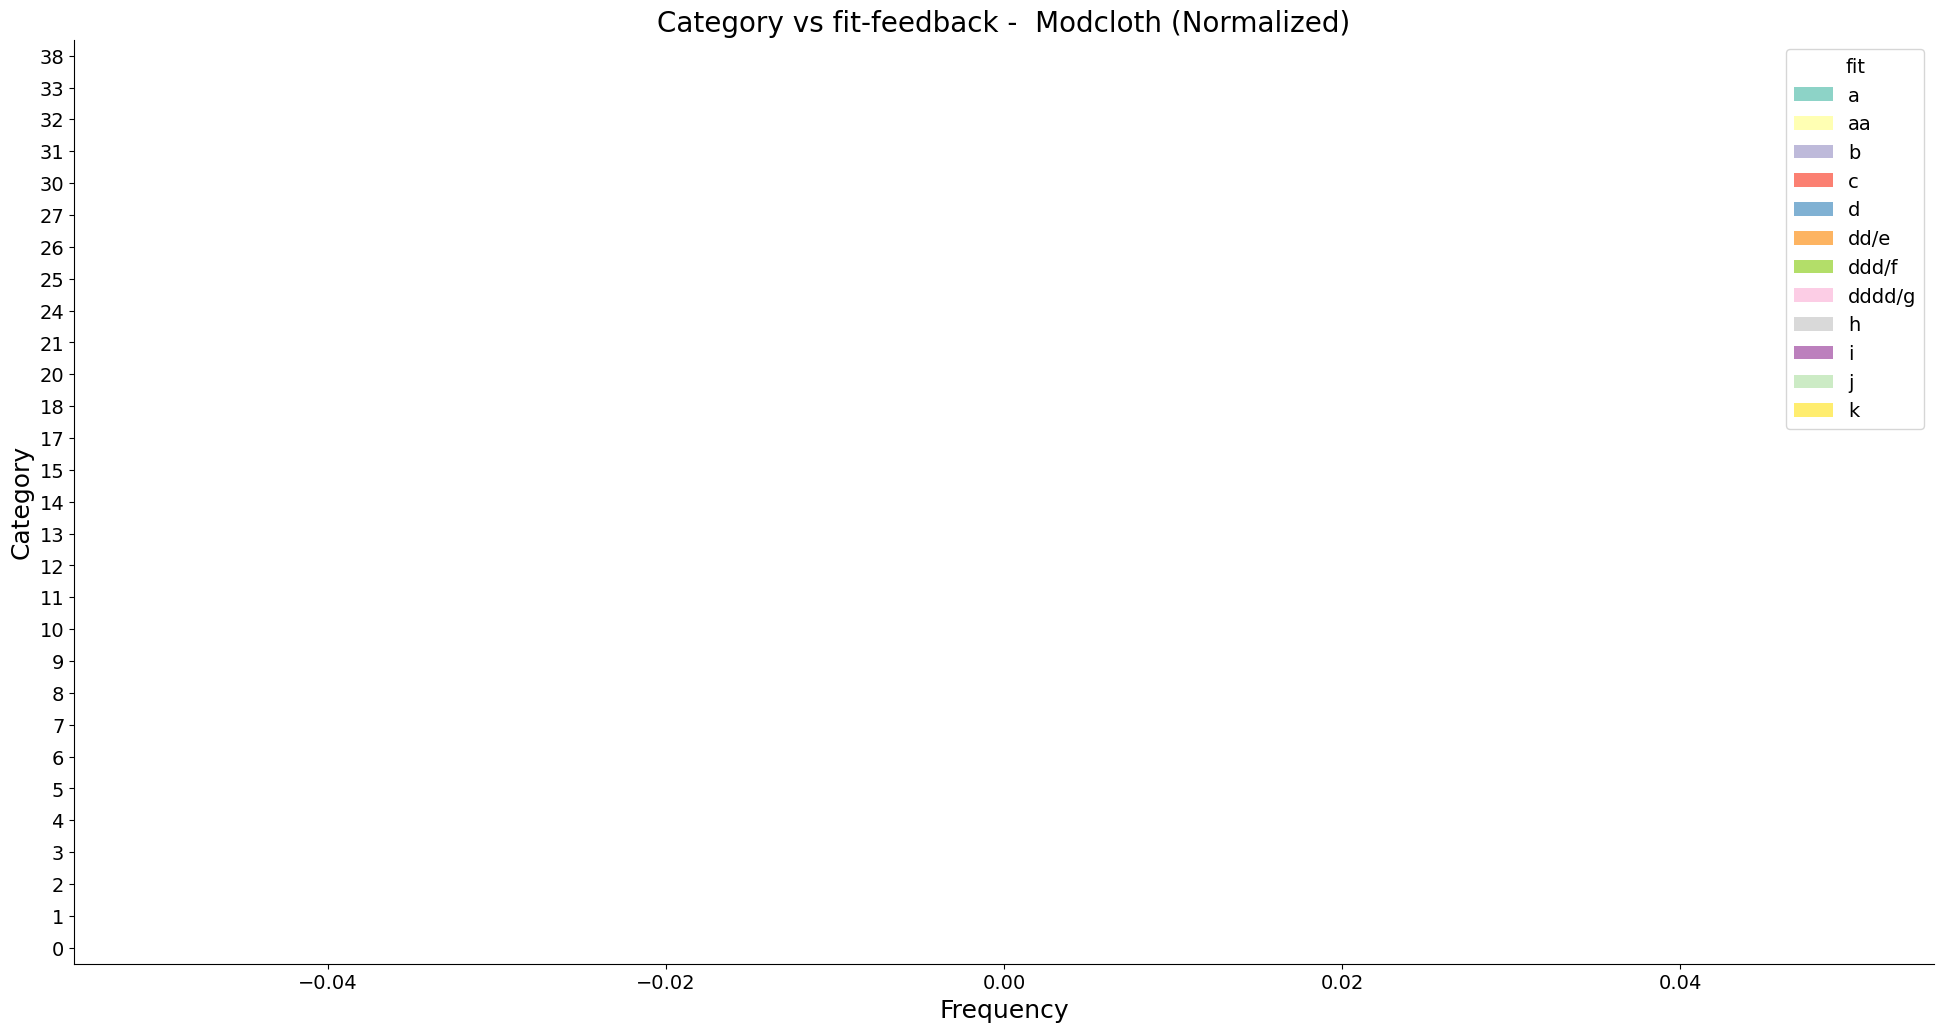

In [32]:
plot_barh(cat_fit_norm, 'fit', norm=1, cmap='Set3')

Здесь мы видим, что среди самих категорий:
* Категории свадебных платьев, топов и верхней одежды обычно имеют больше возвратов из-за больших размеров.
* Новые, распродажные и нижние, как правило, часто возвращаются из-за покупок небольшого размера.
* У платьев аналогичные причины возврата, с точки зрения посадки.

- **Category vs Length**

In [33]:
cat_len = g_by_category['length'].value_counts()
cat_len = cat_len.unstack()
plot_barh(cat_len, 'length', 'Set3')

TypeError: no numeric data to plot

* Лучшая посадка по длине ("в самый раз") относится к топам, новинкам, платьям и низам! (Также из-за преобладания этих категорий в общем объеме наших сделок - ** они составляют почти 92% наших сделок!**)
* Все транзакции имеют одинаковый порядок причин возврата (в порядке важности), что также интуитивно понятно:
 * немного длинный
 * немного короткий
 * очень длинный
 * очень короткий

In [34]:
cat_len_norm = norm_counts(cat_len)
cat_len_norm.drop(['just right'], axis = 1, inplace=True)
plot_barh(cat_len_norm, 'length', cmap='Set3', norm=1)

KeyError: "['just right'] not found in axis"

Нормализованный график, фокусирующийся на проблемах, позволяет нам глубже разобраться в причинах возврата по категориям:
* Клиенты, как правило, совершают "слегка затянутые" покупки в категориях "низ", "новинка", "распродажа" и "верх".
* "слегка короткие" возвраты происходят в основном в категориях "платья" и "свадьба".

- **Категория в сравнении с качеством**

In [ ]:
cat_quality = g_by_category['quality'].value_counts()
cat_quality = cat_quality.unstack()
plot_barh(cat_quality, 'quality', 'Set3', stacked=1)

* Почти одинаковое количество людей оценили категории *топы, новинки, платья и низ* на 5, 4 и 3.
* Все тенденции с точки зрения доли оценок, по-видимому, постоянны в разных категориях.

In [ ]:
cat_quality_norm = norm_counts(cat_quality)
cat_quality_norm.drop([5.0], axis = 1, inplace=True)
plot_barh(cat_quality_norm, 'quality', 'Set3', stacked=1, norm=1)

* Здесь мы также можем подтвердить наше предыдущее наблюдение, что все категории имеют одинаковую долю оценок.
* Для придирчивых- *новинка, распродажа и топы*, похоже, имеют более высокую, чем обычно, долю плохих оценок (1.0 и 2.0) с точки зрения качества.

<a id="15"></a>
### 2. Общее количество пользователей в сравнении с общим количеством купленных товаров
Визуализируя общее количество пользователей, купивших *x* количество товаров, где мы подтверждаем утверждение автора [[1]] (#ссылки) о том, что данные очень скудны и большая часть (38,45%) пользователей купила только 1 товар на веб-сайте за это время. данные были собраны.

In [35]:
# Users who bought so many items
items_bought = []
total_users = []
for i in range(min(mc_df.user_id.value_counts()), max(mc_df.user_id.value_counts())+1):
    all_users = sum(mc_df.user_id.value_counts() == i)
    if all_users != 0:
        total_users.append(all_users)
        items_bought.append(i)
plt.xlabel("Number of items bought", fontsize = 18)
plt.ylabel("Number of users", fontsize = 18)
plt.title("Distribution of items bought by users on Modcloth")
__ = sns.barplot(x=items_bought, y=total_users, color='y')
fig = plt.gcf()
fig.set_size_inches(20,10)

ValueError: min() arg is an empty sequence

*** Большая часть пользователей (~40%) купили только 1 товар в Modcloth** за время сбора этих данных. Хотя мы обнаружили, что только 903 из них были пользователями впервые (предыдущих данных об этих клиентах не существовало). Это объясняет и подтверждает заявление куратора набора данных о разреженности данных.
* Большинство пользователей купили 1, 2 или 3 продукта у Modcloth из ~80 000 транзакций в этом наборе данных.

<a id="16"></a>
## 3. Соотношение роста и размера обуви - покупатели модной одежды
Было бы интересно посмотреть, существует ли линейная зависимость между ростом человека и размером его обуви, т.е. - это будет означать, что размер обуви увеличивается с увеличением роста!

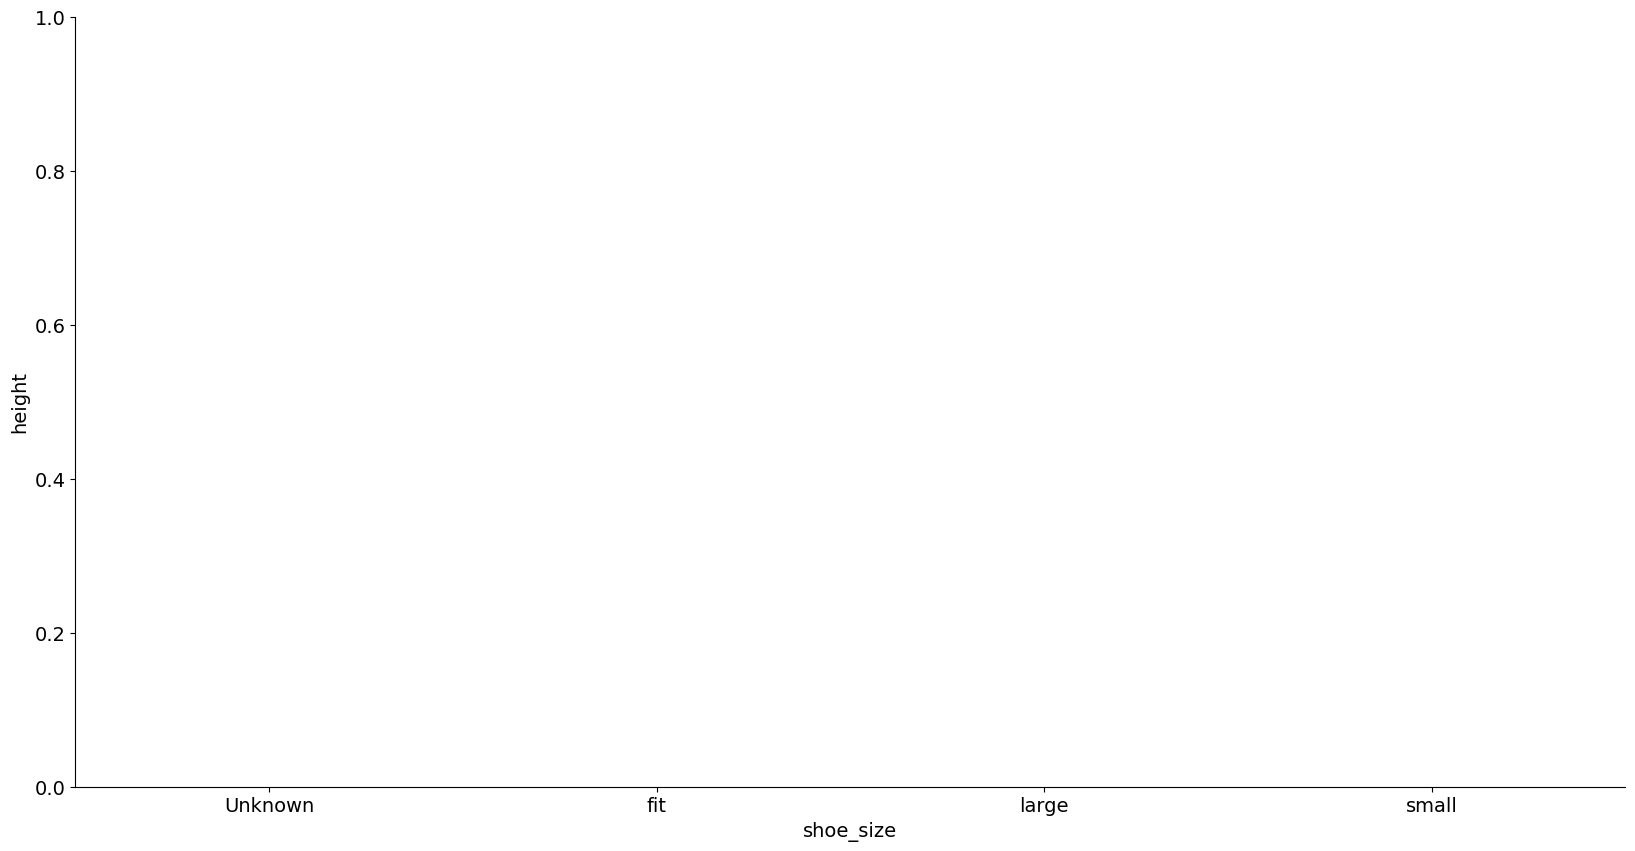

In [36]:
fig = plt.gcf()
fig.set_size_inches(20,10)
__ = sns.violinplot(x='shoe_size', y='height',data=mc_df, size = 20)

Здесь мы можем видеть "линейную корреляцию между размером стопы и ростом". Это наблюдение также было замечено [здесь](https://www.statcrunch.com/5.0/viewreport.php?reportid=35115).

<a id='ссылки'></a>
# Ссылки:
 [1] Ришаб Мисра, Менгтинг Ван, Джулиан Маколи, анализирующие семантику соответствия для рекомендации размера продукта в метрических пространствах. RecSys, 2018.
 
<a id='допущения'></a>
# Допущения:
В наборе данных Modcloth источник данных был выбран следующим образом: 
* item_id - из элемента.
* талия - из пользовательского ввода.
* размер - из элемента.
* качество - из пользовательского ввода.
* размер чашки - из пользовательского ввода.
* бедра - из пользовательского ввода.
* размер бюстгальтера - из пользовательского ввода.
* категория - из товара.
* бюст - из пользовательского ввода.
* рост - из пользовательского ввода
* имя_пользователя - из пользовательского ввода
* длина - из пользовательского ввода
* соответствие - из пользовательского ввода
* идентификатор пользователя - из пользовательского ввода.


*Адитья Агравал*